# Assignment: Visualization
### `! git clone https://github.com/ds3001f25/visualization_assignment.git`
### Do Q1 and Q2.

# Q1

**Q1.** Write your own function to make a kernel density plot.

- The user should pass in a Pandas series or Numpy array.
- The default kernel should be Gaussian, but include the uniform/bump and Epanechnikov as alternatives.
- The default bandwidth should be the Silverman plug-in, but allow the user to specify an alternative.
- You can use Matplotlib or Seaborn's `.lineplot`, but not an existing function that creates kernel density plots.

You will have to make a lot of choices and experiment with getting errors. Embrace the challenge and track your choices in the comments in your code.

Use the pretrail data set from class to show that your function works, and compare it with the Seaborn `kdeplot`.

We covered the Gaussian,
$$
k(z) = \dfrac{1}{\sqrt{2\pi}}e^{-z^2/2}
$$
and uniform 
$$
k(z) = \begin{cases} 
\frac{1}{2}, & |z| \le 1 \\
0, & |z|>1
\end{cases}
$$
kernels in class, but the Epanechnikov kernel is 
$$
k(z) = \begin{cases} 
\frac{3}{4} (1-z^2), & |z| \le 1 \\
0, & |z|>1.
\end{cases}
$$

In order to make your code run reasonably quickly, consider using the `pdist` or `cdist` functions from SciPy to make distance calculations for arrays of points. The other leading alternative is to thoughtfully use NumPy's broadcasting features. Writing `for` loops will be slow, but that's fine.

In [2]:
''' 
3 options gaussian, uniform, epanechnikov kernel
kde = f_hat(x) = (1/(n*h)) * sum_i K( (x - x_i)/h ) ? from notes

default kernel = gaussian, alt options = uniform + epanechnikov
silverman plugin = h = 1.06 * sd * N**(-1/5) <- set as default but user can override

Grid:
choose M grid points (e.g., M=500) 
range: from min_x - 2*sd to max_x + 2*sd ---> plus/minus 2 sd padding

each point gets a bell curve --> gotta center kernel at every data point and summing 
from notes: rugplot -> little bells -> sum

choosing btwn cdist or numpy broadcasting... 

validate by plotting compared to seaborn
'''

' \n3 options gaussian, uniform, epanechnikov kernel\nkde = f_hat(x) = (1/(n*h)) * sum_i K( (x - x_i)/h ) ? from notes\n\ndefault kernel = gaussian, alt options = uniform + epanechnikov\nsilverman plugin = h = 1.06 * sd * N**(-1/5) <- set as default but user can override\n\nGrid:\nchoose M grid points (e.g., M=500) \nrange: from min_x - 2*sd to max_x + 2*sd ---> plus/minus 2 sd padding\n\neach point gets a bell curve --> gotta center kernel at every data point and summing \nfrom notes: rugplot -> little bells -> sum\n\nchoosing btwn cdist or numpy broadcasting... \n\nvalidate by plotting compared to seaborn\n'

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# refer notes, using default plugin 
def silverman(x):
    x = np.asarray(x, float)
    x = x[~np.isnan(x)]
    n = x.size
    if n < 2:
        raise ValueError("need 2 or more data points for bandwidth ? ")
    sd = np.std(x)
    h  = 1.06 * sd * n**(-1/5)                    
    return h

# determining kernel by name, default gaussian
def kernel(z, name):
    name = str(name).lower()

    if name in ("gaussian","normal"):
        # from notes: (1/sqrt(2π)) * exp(-z^2/2)
        return np.exp(-0.5 * z*z) / np.sqrt(2*np.pi)
    az = np.abs(z)

    if name in ("uniform","bump"):
        # 1/2 on |z|<=1, else 0
        out = np.zeros_like(z, float)
        out[az <= 1] = 0.5
        return out
    
    # i am not typing the full name every time
    if name in ("epanechnikov","epa"): 
        # (3/4)*(1 - z^2) on |z|<=1, else 0
        out = np.zeros_like(z, float)
        m = az <= 1
        out[m] = 0.75 * (1 - z[m]*z[m])
        return out
    raise ValueError("kernel must be 'gaussian', 'uniform', or 'epanechnikov'")


def kde_plot(data, kernel_name="gaussian", bandwidth="silverman", M=500, ax=None, label=None):
    # data cleaning
    x = np.asarray(data, float).ravel()
    x = x[~np.isnan(x)]
    if x.size == 0:
        raise ValueError("no data after dropping nan")
    n = x.size

    # 1 choosing h -> deafult silverman
    if bandwidth == "silverman":
        h = silverman(x) # encapsulation bc this method is getting too long
    else:
        h = float(bandwidth)  # user inputted bandwidth
        if h <= 0: raise ValueError("bandwidth must be > 0")

    # 2 grid = np.linspace(min_x-2*sd,max_x+2*sd,M)
    sd = np.std(x)
    # sd = np.std(x, ddof=1) if x.size > 1 else 1.0
    xmin, xmax = np.min(x), np.max(x)
    grid = np.linspace(xmin - 2*sd, xmax + 2*sd, int(M))

    # 3 vectorized Z = (grid - x_i)/h for all grid points × samples
    # numpy broadcasting to build the grid without looping through (time save)
    Z = (grid[:, None] - x[None, :]) / h

    # 4 evaluate kernel & apply KDE formula
    # f_hat(grid_j) = (1/(n*h)) * sum_i K( Z[j,i] )
    K = kernel(Z, kernel_name)
    density = K.sum(axis=1) / (n * h)

    # 5 matplotlib line
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(grid, density, label=label if label else f"{kernel_name}, h={h:.3g}")
    ax.set_xlabel("x")
    ax.set_ylabel("density")
    ax.set_title("KDE")
    if label:
        ax.legend()

    return grid, density, h, ax

### visualizing pretrial df

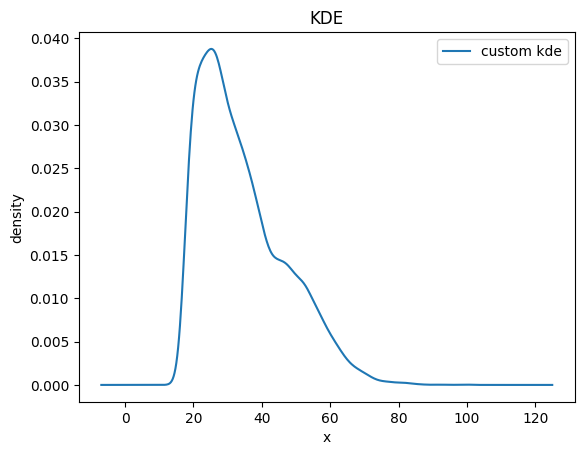

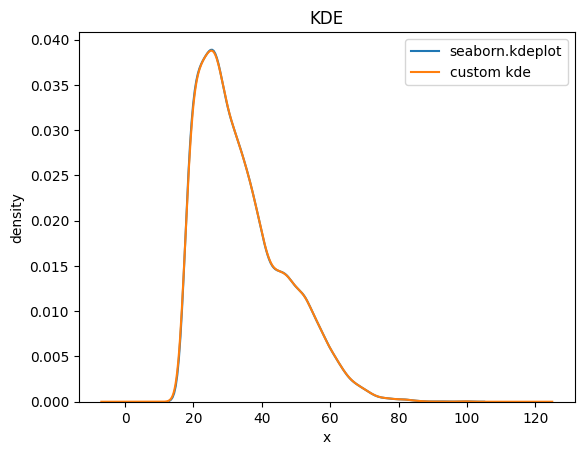

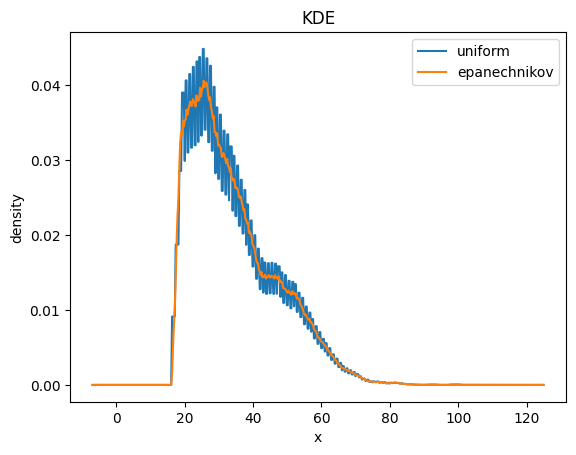

In [4]:
import pandas as pd
import seaborn as sns

pretrial_df = pd.read_csv("./data/pretrial_data.csv")

col = pretrial_df['age']

# custom kde
grid, dens, h, ax = kde_plot(col, kernel_name="gaussian", bandwidth="silverman", M=500, label="custom kde")
plt.show()

# compare w seaborns kdeplot
import seaborn as sns
ax = sns.kdeplot(col, fill=False, label="seaborn.kdeplot")
kde_plot(col, kernel_name="gaussian", bandwidth="silverman", M=500, ax=ax, label="custom kde")
plt.legend(); plt.show()

# showing other kernels too
ax = None
for k in ["uniform","epanechnikov"]:
    _, _, _, ax = kde_plot(col, kernel_name=k, bandwidth="silverman", M=500, ax=ax, label=k)
plt.show()

# Q2

**Q2.** This question provides some practice doing exploratory data analysis and visualization.

The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `./data/college_completion.csv` data with Pandas.
2. What are are the dimensions of the data? How many observations are there? What are the variables included? Use `.head()` to examine the first few rows of data.
3. Cross tabulate `control` and `level`. Describe the patterns you see.
4. For `grad_100_value`, create a histogram, kernel density plot, boxplot, and statistical description.
5. For `grad_100_value`, create a grouped kernel density plot by `control` and by `level`. Describe what you see. Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `grad_100_value` by `level` and `control`. Which institutions appear to have the best graduation rates?
6. Create a new variable, `df['levelXcontrol']=df['level']+', '+df['control']` that interacts level and control. Make a grouped kernel density plot. Which institutions appear to have the best graduation rates?
7. Make a kernel density plot of `aid_value`. Now group your graph by `level` and `control`. What explains the shape of the graph? Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `aid_value` by `level` and `control`.
8. Make a scatterplot of `grad_100_value` by `aid_value`. Describe what you see. Now make the same plot, grouping by `level` and then `control`. Describe what you see. For which kinds of institutions does aid seem to increase graduation rates?

### 2.1.
 Load the `./data/college_completion.csv` data with Pandas.

In [5]:
college_df = pd.read_csv("./data/college_completion.csv")

### 2.2
 What are are the dimensions of the data? How many observations are there? What are the variables included? Use `.head()` to examine the first few rows of data.

In [6]:
print(college_df.shape)
print(college_df.columns)
college_df.head()


(3798, 63)
Index(['index', 'unitid', 'chronname', 'city', 'state', 'level', 'control',
       'basic', 'hbcu', 'flagship', 'long_x', 'lat_y', 'site', 'student_count',
       'awards_per_value', 'awards_per_state_value', 'awards_per_natl_value',
       'exp_award_value', 'exp_award_state_value', 'exp_award_natl_value',
       'exp_award_percentile', 'ft_pct', 'fte_value', 'fte_percentile',
       'med_sat_value', 'med_sat_percentile', 'aid_value', 'aid_percentile',
       'endow_value', 'endow_percentile', 'grad_100_value',
       'grad_100_percentile', 'grad_150_value', 'grad_150_percentile',
       'pell_value', 'pell_percentile', 'retain_value', 'retain_percentile',
       'ft_fac_value', 'ft_fac_percentile', 'vsa_year',
       'vsa_grad_after4_first', 'vsa_grad_elsewhere_after4_first',
       'vsa_enroll_after4_first', 'vsa_enroll_elsewhere_after4_first',
       'vsa_grad_after6_first', 'vsa_grad_elsewhere_after6_first',
       'vsa_enroll_after6_first', 'vsa_enroll_elsewhere_after6

,index,unitid,chronname,city,state,level,control,basic,hbcu,flagship,...,vsa_grad_after6_transfer,vsa_grad_elsewhere_after6_transfer,vsa_enroll_after6_transfer,vsa_enroll_elsewhere_after6_transfer,similar,state_sector_ct,carnegie_ct,counted_pct,nicknames,cohort_size
0,0,100654,Alabama A&M University,Normal,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,...,36.4,5.6,17.2,11.1,232937|100724|405997|113607|139533|144005|2285...,13,386,99.7|07,NaN,882.0
1,1,100663,University of Alabama at Birmingham,Birmingham,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,...,NaN,NaN,NaN,NaN,196060|180461|201885|145600|209542|236939|1268...,13,106,56.0|07,UAB,1376.0
2,2,100690,Amridge University,Montgomery,Alabama,4-year,Private not-for-profit,Baccalaureate Colleges--Arts & Sciences,NaN,NaN,...,NaN,NaN,NaN,NaN,217925|441511|205124|247825|197647|221856|1353...,16,252,100.0|07,NaN,3.0
3,3,100706,University of Alabama at Huntsville,Huntsville,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,...,0.0,0.0,0.0,0.0,232186|133881|196103|196413|207388|171128|1900...,13,106,43.1|07,UAH,759.0
4,4,100724,Alabama State University,Montgomery,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,...,NaN,NaN,NaN,NaN,100654|232937|242617|243197|144005|241739|2354...,13,386,88.0|07,ASU,1351.0


The dimensions of the data is 3798 rows and 63 columns, which means there are 3798 observations and 63 variables which are available above.

### 2.3
Cross tabulate `control` and `level`. Describe the patterns you see.


In [7]:
ct = pd.crosstab(college_df["control"], college_df["level"])
ct.head()

level,2-year,4-year
control,,
Private for-profit,465,527
Private not-for-profit,68,1180
Public,926,632


It seems like it's relatively even between the 2 year and 4 year levels for the number of private, for profit colleges yet there is a significant increase in 4 year private non profit colleges at a 4 year level, with it being close to 17 times more than the number of 2 year private non profit colleges. As for public options, the 2 year level seems to have 150% of the 4 year level yet there is still a considerable number of public 4 year options. It seems overall, there are more 4 year institutions, particularly private non profit ones.

### 2.4
 For `grad_100_value`, create a histogram, kernel density plot, boxplot, and statistical description.


In [8]:
college_df["grad_100_value"].describe()

count    3467.000000
mean       28.364465
std        23.312730
min         0.000000
25%         9.000000
50%        22.500000
75%        43.650000
max       100.000000
Name: grad_100_value, dtype: float64

<Axes: >

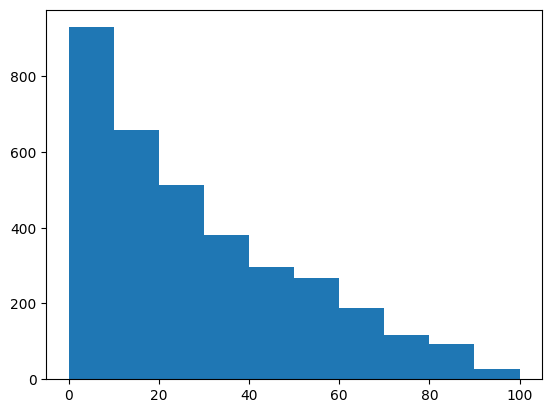

In [9]:
college_df["grad_100_value"].hist(grid=False)

<Axes: >

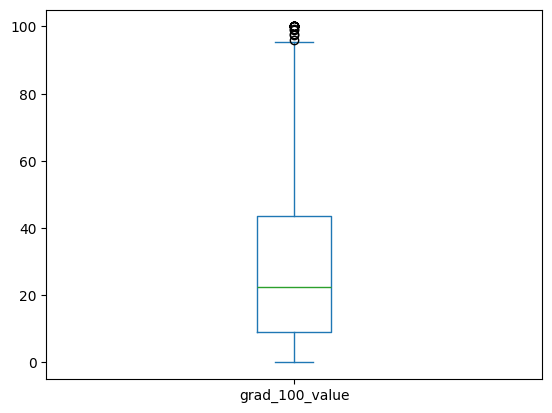

In [10]:
college_df["grad_100_value"] = pd.to_numeric(college_df["grad_100_value"], errors='coerce')
college_df["grad_100_value"].plot.box()

<Axes: ylabel='Density'>

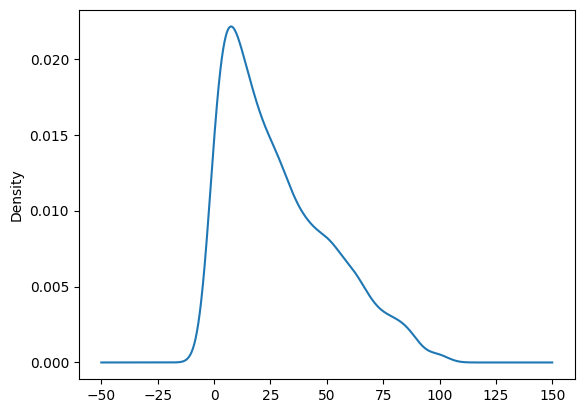

In [11]:
college_df["grad_100_value"].plot.density()

### 2.5
 For `grad_100_value`, create a grouped kernel density plot by `control` and by `level`. Describe what you see. Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `grad_100_value` by `level` and `control`. Which institutions appear to have the best graduation rates?


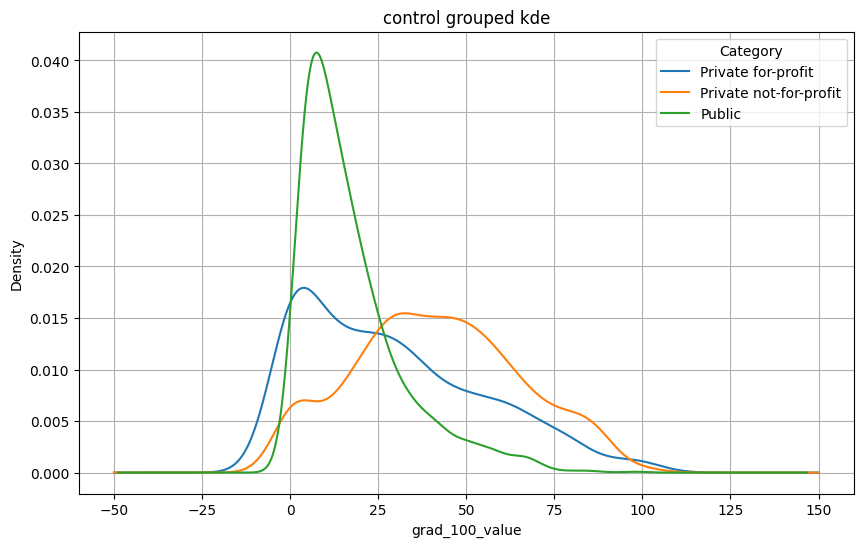

In [13]:
control_grouped = college_df.groupby('control')
plt.figure(figsize=(10, 6))
for name, group in control_grouped:
    group['grad_100_value'].plot.kde(label=name)

plt.title('control grouped kde')
plt.xlabel('grad_100_value')
plt.ylabel('Density')
plt.legend(title='Category')
plt.grid(True)
plt.show()

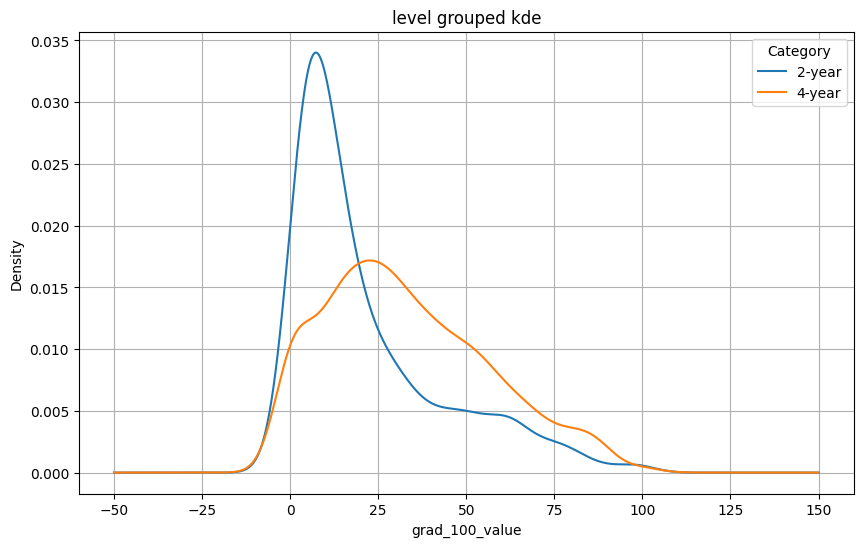

In [14]:
level_grouped = college_df.groupby('level')
plt.figure(figsize=(10, 6))
for name, group in level_grouped:
    group['grad_100_value'].plot.kde(label=name)

plt.title('level grouped kde')
plt.xlabel('grad_100_value')
plt.ylabel('Density')
plt.legend(title='Category')
plt.grid(True)
plt.show()

From the control grouped kernel density plot, we can see that private not for profit institutions have their graduation rates more spread out, with most schools in the range of 30-70% and this group seems to have higher general graduation rates than the other two types of insitutions. We can see that public is peaked close to 10-15% graduation rate which means a high density of that graduation rate and that private for profit also in the same boat with lower graduation rates. </br> </br>

As for the level, it seems like 4 year institutions have higher graduation rates as well since the plot for 2 year institutions indicates that there is a high density towards 10% graduation rates which is not indicative of having high graduation rates.

### 2.6
Create a new variable, `df['levelXcontrol']=df['level']+', '+df['control']` that interacts level and control. Make a grouped kernel density plot. Which institutions appear to have the best graduation rates?


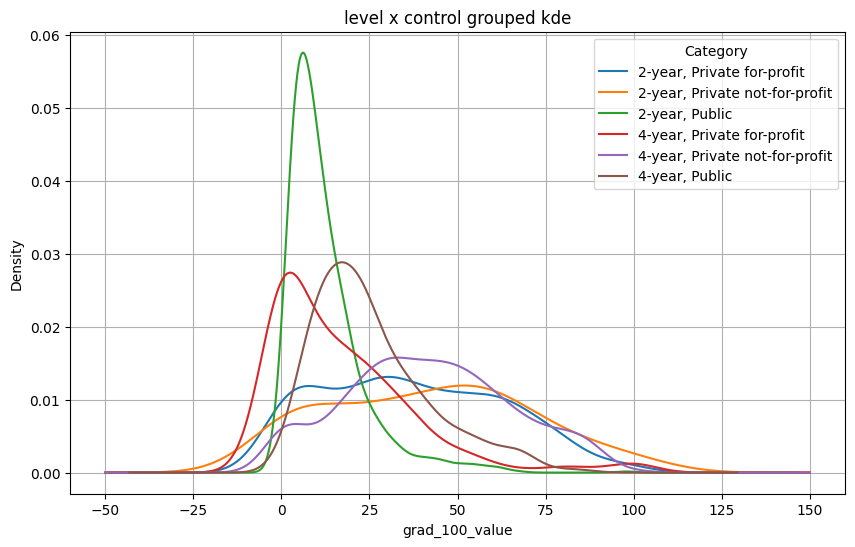

In [15]:
college_df['levelXcontrol']=college_df['level']+', '+ college_df['control']
lvlctrl_grouped = college_df.groupby('levelXcontrol')
plt.figure(figsize=(10, 6))
for name, group in lvlctrl_grouped:
    group['grad_100_value'].plot.kde(label=name)

plt.title('level x control grouped kde')
plt.xlabel('grad_100_value')
plt.ylabel('Density')
plt.legend(title='Category')
plt.grid(True)
plt.show()

From here we can see that a mix of 4 year private not for profit, 2 year private not for profit, and 2 year private for profit do have higher graduation rates overall, as the other three options seem to have their graduation rates highly concentrated between 0-25% graduation rates so we can say that the first three options are better options for having a high graduation rate. 

### 2.7
Make a kernel density plot of `aid_value`. Now group your graph by `level` and `control`. What explains the shape of the graph? Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `aid_value` by `level` and `control`.


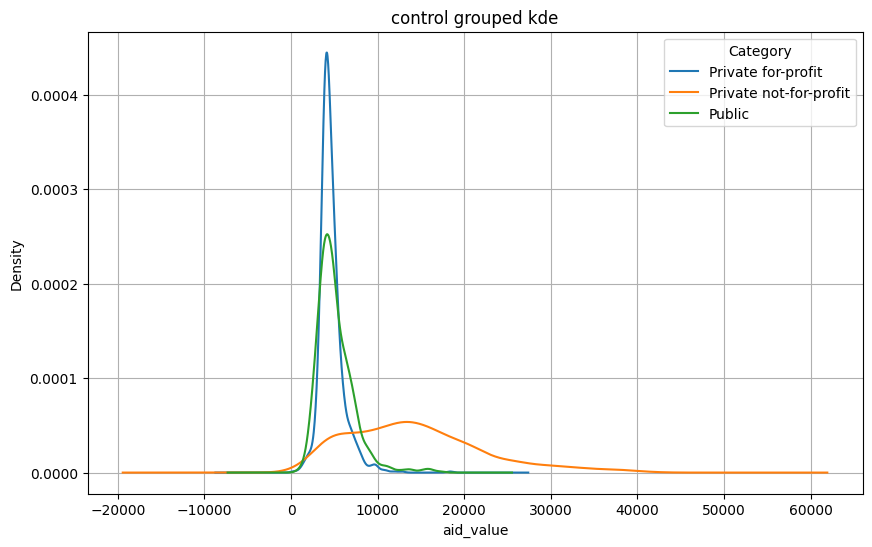

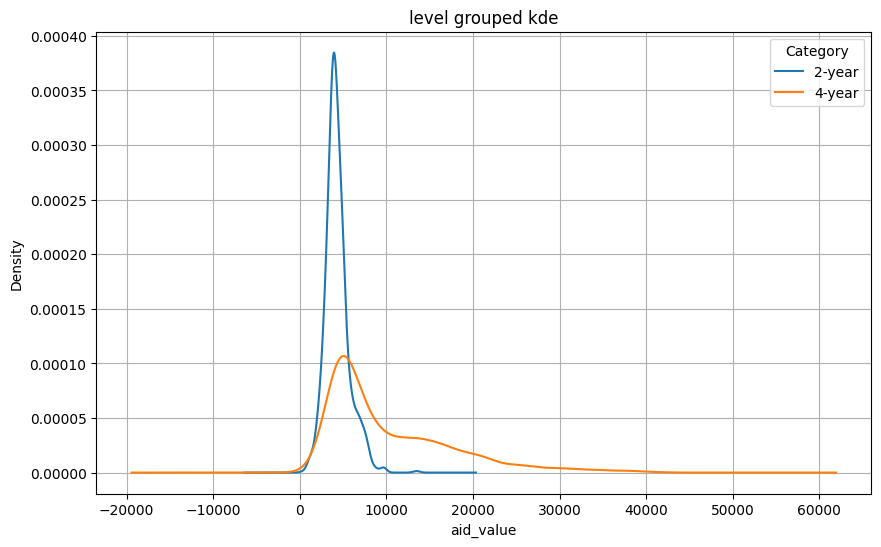

In [18]:
# using control grouped
plt.figure(figsize=(10, 6))
for name, group in control_grouped:
    group['aid_value'].plot.kde(label=name)

plt.title('control grouped kde')
plt.xlabel('aid_value')
plt.ylabel('Density')
plt.legend(title='Category')
plt.grid(True)
plt.show()

# using level grouped
plt.figure(figsize=(10, 6))
for name, group in level_grouped:
    group['aid_value'].plot.kde(label=name)

plt.title('level grouped kde')
plt.xlabel('aid_value')
plt.ylabel('Density')
plt.legend(title='Category')
plt.grid(True)
plt.show()

In [19]:
control_grouped["aid_value"].describe()

,count,mean,std,min,25%,50%,75%,max
control,,,,,,,,
Private for-profit,991.0,4632.206862,1399.121259,294.0,3861.50,4331.0,5131.5,18355.0
Private not-for-profit,1248.0,14180.722756,7772.700998,902.0,8325.00,13322.0,18571.0,41580.0
Public,1558.0,5094.835687,2136.436370,881.0,3725.25,4667.0,6087.5,17299.0


In [20]:
level_grouped["aid_value"].describe()

,count,mean,std,min,25%,50%,75%,max
level,,,,,,,,
2-year,1458.0,4310.878601,1384.045631,294.0,3485.5,4113.0,4890.0,13654.0
4-year,2339.0,10235.379222,7227.369167,902.0,4830.5,7222.0,14046.0,41580.0


The graph looks the way it does since there are peaks where there is high density/number of records that say that they received around $5000 in aid for 2 year institutions, private for profit, and public institutions. For 4 year institutions, it seems like the amount of aid is a bit higher yet it is more distributed, where its more centered $10,000 so the aid is higher.

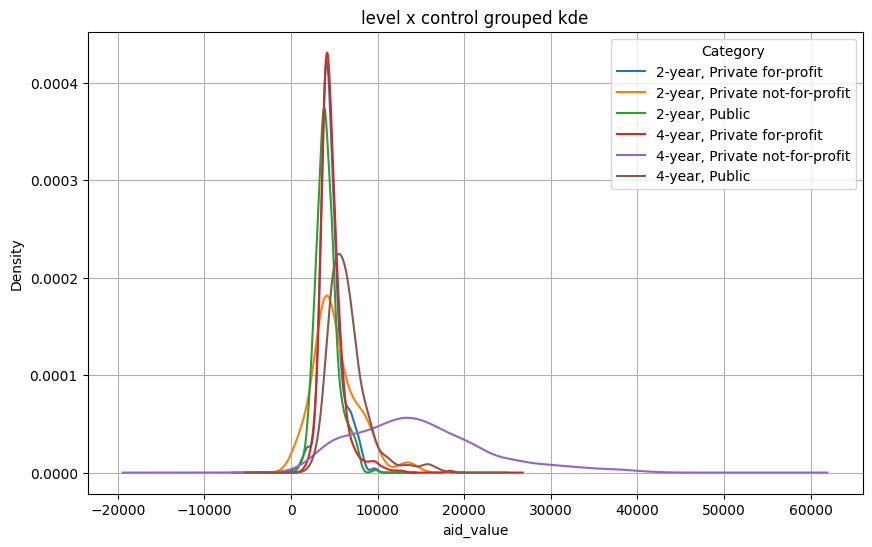

In [21]:
# using levelxcontrol grouped
plt.figure(figsize=(10, 6))
for name, group in lvlctrl_grouped:
    group['aid_value'].plot.kde(label=name)

plt.title('level x control grouped kde')
plt.xlabel('aid_value')
plt.ylabel('Density')
plt.legend(title='Category')
plt.grid(True)
plt.show()

From this plot, we can see that 4 year private not for profit have the highest financial aid based on the centering and distribution around $15,000.

### 2.8
Make a scatterplot of `grad_100_value` by `aid_value`. Describe what you see. Now make the same plot, grouping by `level` and then `control`. Describe what you see. For which kinds of institutions does aid seem to increase graduation rates?

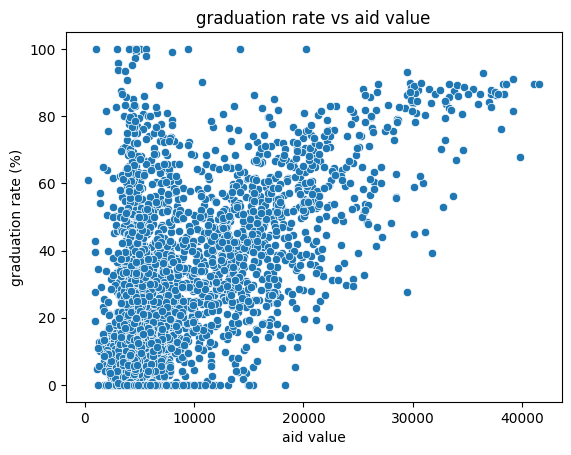

In [22]:
fig = sns.scatterplot(data=college_df, x='aid_value', y='grad_100_value')
fig.set(title="graduation rate vs aid value", xlabel="aid value", ylabel="graduation rate (%)")
plt.show()

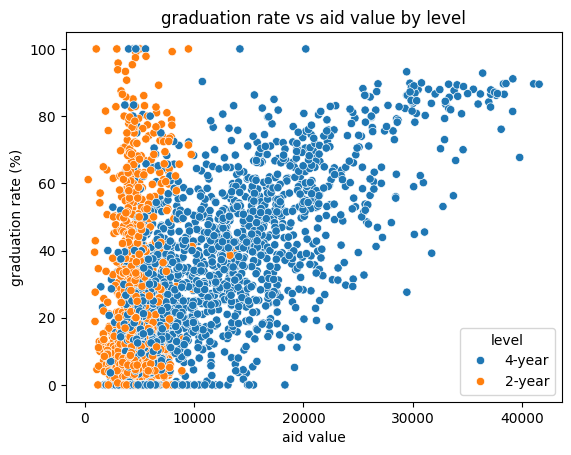

In [23]:
fig = sns.scatterplot(data=college_df, x='aid_value', y='grad_100_value', hue='level')
fig.set(title="graduation rate vs aid value by level", xlabel="aid value", ylabel="graduation rate (%)")
plt.show()

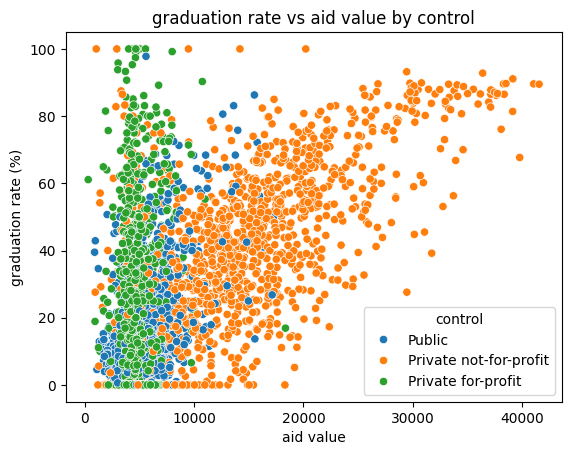

In [24]:
fig = sns.scatterplot(data=college_df, x='aid_value', y='grad_100_value', hue='control')
fig.set(title="graduation rate vs aid value by control", xlabel="aid value", ylabel="graduation rate (%)")
plt.show()

It seems very evident that 4 year colleges have higher graduation rates, while 2 year colleges don't seem to explicitly have a higher graduation rate but rather it's spread somewhat evenly between 0-100%. The last plot shows that private not for profit colleges make up the majority of those with higher aid values and that it does seem that higher aid does increase graduation rate for these private not for profit schools.